
各列缺失值统计：
nozzle_diameter    153
printing_speed     109
extrusion_speed     89
extrusion_temp      14
extruder_type       12
filament_aspect     10
platform_temp        8
dtype: int64
DataFrame 维度: (1172, 331)


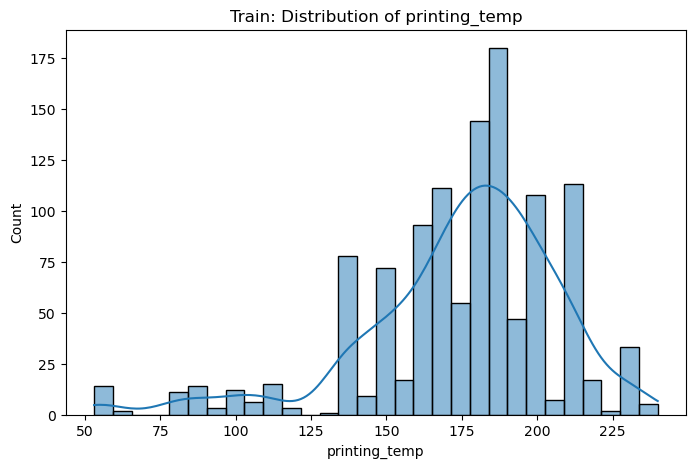

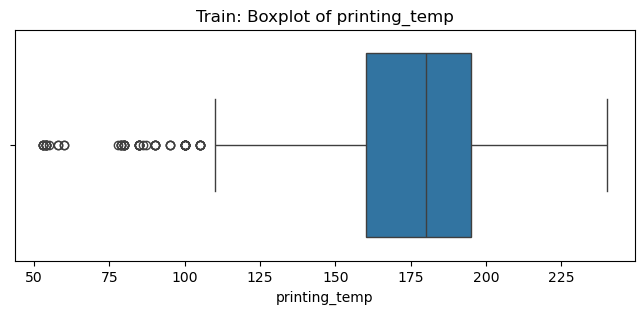

=== Target Descriptive Statistics ===
count    1172.000000
mean      174.903584
std        32.783990
min        53.000000
25%       160.000000
50%       180.000000
75%       195.000000
max       240.000000
Name: printing_temp, dtype: float64 

Skewness: -1.193
Kurtosis: 2.133


In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tqdm import tqdm


# 1. 读取数据
df = pd.read_excel(r"D:\ML-3DPrinting-Project\data\7.9_datasets\2_regression_original.xlsx")

# 2. 删除不需要的列
#drop_cols = ['article']
#df = df.drop(columns=drop_cols)
 
# 3. 丢弃高缺失列 & 目标缺失行
df = df.dropna(axis=1, thresh=len(df)*0.5)
target_col = "printing_temp"
df = df.dropna(subset=[target_col]).reset_index(drop=True)

# 4.统计各列缺失值
missing_counts = df.isnull().sum().sort_values(ascending=False)
print("\n各列缺失值统计：")
print(missing_counts[missing_counts > 0])

# 5. 查看维度
print(f"DataFrame 维度: {df.shape}")

# 1. 划分 X, y
X = df.drop(columns=[target_col])
y = df[target_col]


# 2. 标签分布可视化 & 统计
plt.figure(figsize=(8,5))
sns.histplot(y, bins=30, kde=True)
plt.title(f"Train: Distribution of {target_col}")
plt.show()

plt.figure(figsize=(8,3))
sns.boxplot(x=y)
plt.title(f"Train: Boxplot of {target_col}")
plt.show()

print("=== Target Descriptive Statistics ===")
print(y.describe(), "\n")
print(f"Skewness: {skew(y):.3f}")
print(f"Kurtosis: {kurtosis(y):.3f}")


In [2]:
# === Step 2: 数据集划分（在任何编码、标准化之前）===
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# === Step 3: 添加缺失标志列（数值列）===
def add_missing_flags(X_raw):
    num_cols = X_raw.select_dtypes(include=['float64', 'int64']).columns
    missing_flags = pd.DataFrame(index=X_raw.index)
    for col in num_cols:
        if X_raw[col].isna().sum() > 0:
            missing_flags[f'{col}_was_missing'] = X_raw[col].isna().astype(int)
    return pd.concat([X_raw, missing_flags], axis=1)

X_train_flagged = add_missing_flags(X_train_raw)
X_test_flagged = add_missing_flags(X_test_raw)

# === Step 4: 类别填补 + One-Hot 编码 ===
cat_cols = X_train_flagged.select_dtypes(include=['object', 'category']).columns
X_train_flagged[cat_cols] = X_train_flagged[cat_cols].fillna("missing")
X_test_flagged[cat_cols] = X_test_flagged[cat_cols].fillna("missing")

X_train_encoded = pd.get_dummies(X_train_flagged, drop_first=True)
X_test_encoded = pd.get_dummies(X_test_flagged, drop_first=True)

# 对齐测试集列（避免缺列）
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
cols = X_train_encoded.columns  # 记录列名用于 SHAP
# === Step 5: 标准化 ===
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_encoded), columns=X_train_encoded.columns, index=X_train_encoded.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_encoded), columns=X_test_encoded.columns, index=X_test_encoded.index)

# === Step 6: 自监督 MLP 填补缺失值 ===
X_train_filled = X_train_scaled.copy()
X_test_filled = X_test_scaled.copy()
X_train_original = X_train_raw.copy()

num_cols = X_train_raw.select_dtypes(include=['float64', 'int64']).columns
filled_features = []

for col in tqdm(num_cols):
    if X_train_original[col].isna().sum() == 0:
        continue

    mask_train = X_train_original[col].isna()
    not_missing_mask = ~mask_train

    valid_cols = [c for c in X_train_scaled.columns if c != col and not X_train_scaled[c].isna().any()]
    if not valid_cols:
        continue

    X_train_feat = X_train_scaled.loc[not_missing_mask, valid_cols]
    y_train_feat = X_train_scaled.loc[not_missing_mask, col]

    model = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42)
    model.fit(X_train_feat, y_train_feat)

    # 填补训练集
    X_missing_feat_train = X_train_scaled.loc[mask_train, valid_cols]
    X_train_filled.loc[mask_train, col] = model.predict(X_missing_feat_train)

    # 填补测试集（注意：使用 train 模型）
    mask_test = X_test_raw[col].isna() if col in X_test_raw.columns else None
    if mask_test is not None and mask_test.any():
        X_missing_feat_test = X_test_scaled.loc[mask_test, valid_cols]
        X_test_filled.loc[mask_test, col] = model.predict(X_missing_feat_test)

    filled_features.append(col)

print(f"已成功填补以下特征缺失: {filled_features}")

100%|████████████████████████████████████████████████████████████████████████████████| 327/327 [00:03<00:00, 93.40it/s]

已成功填补以下特征缺失: ['extrusion_temp', 'extrusion_speed', 'printing_speed', 'platform_temp', 'nozzle_diameter']



📘 Fold 1/10
R2: 0.8717, RMSE: 13.0827, MAE: 8.1884

📘 Fold 2/10
R2: 0.8478, RMSE: 10.1120, MAE: 7.0441

📘 Fold 3/10
R2: 0.7797, RMSE: 16.4620, MAE: 9.0901

📘 Fold 4/10
R2: 0.9248, RMSE: 10.4126, MAE: 5.8183

📘 Fold 5/10
R2: 0.8392, RMSE: 14.9256, MAE: 8.2848

📘 Fold 6/10
R2: 0.8650, RMSE: 13.8337, MAE: 8.5748

📘 Fold 7/10


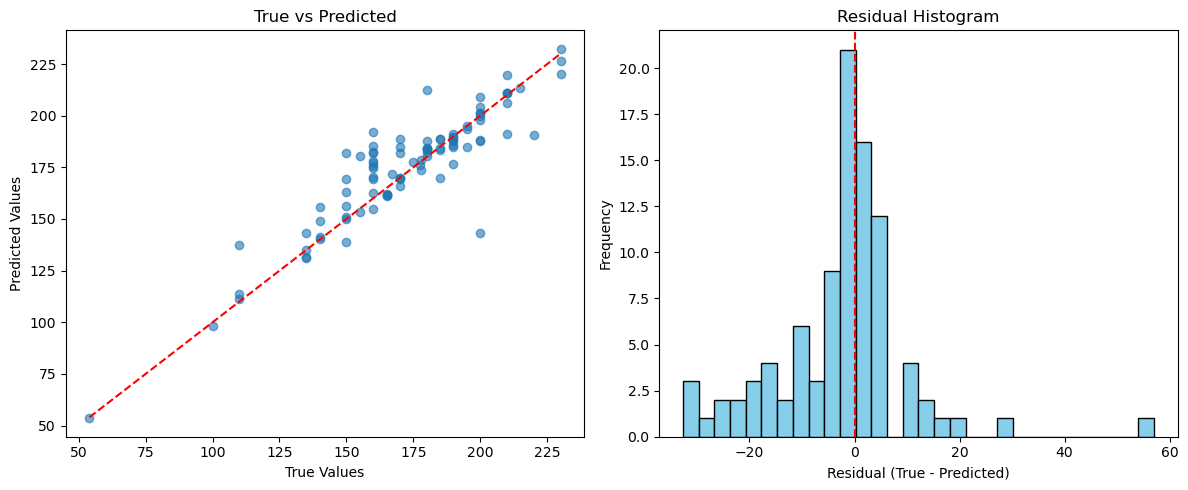

🎯 当前是 Fold 7，开始 SHAP 和 PCA 分析...


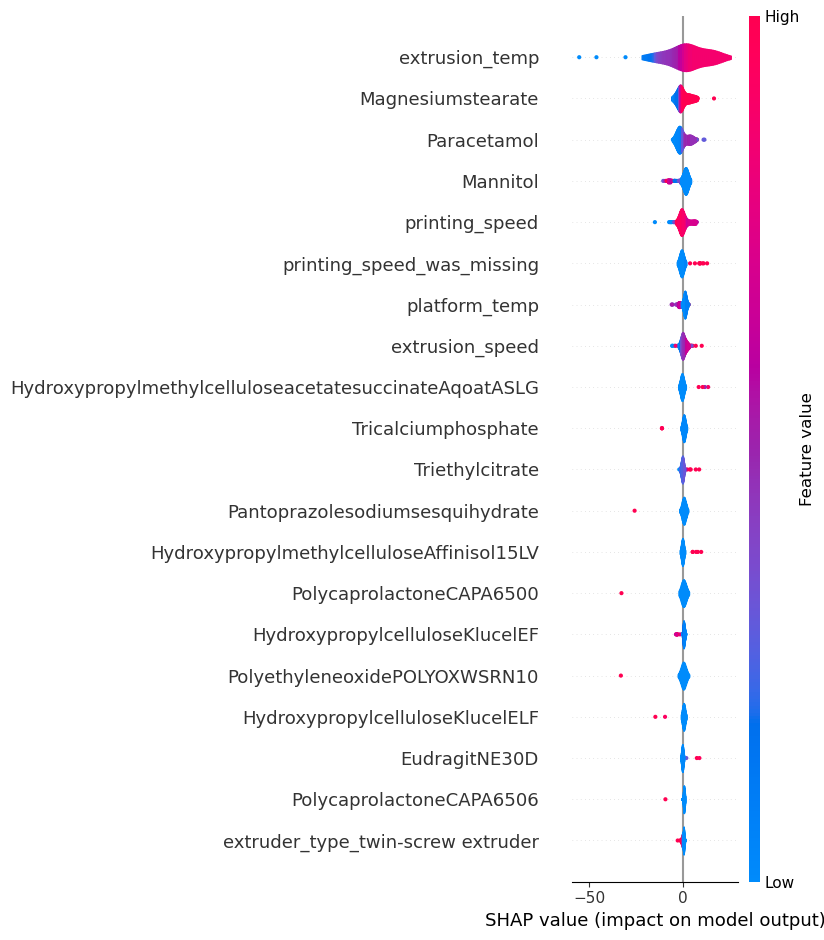

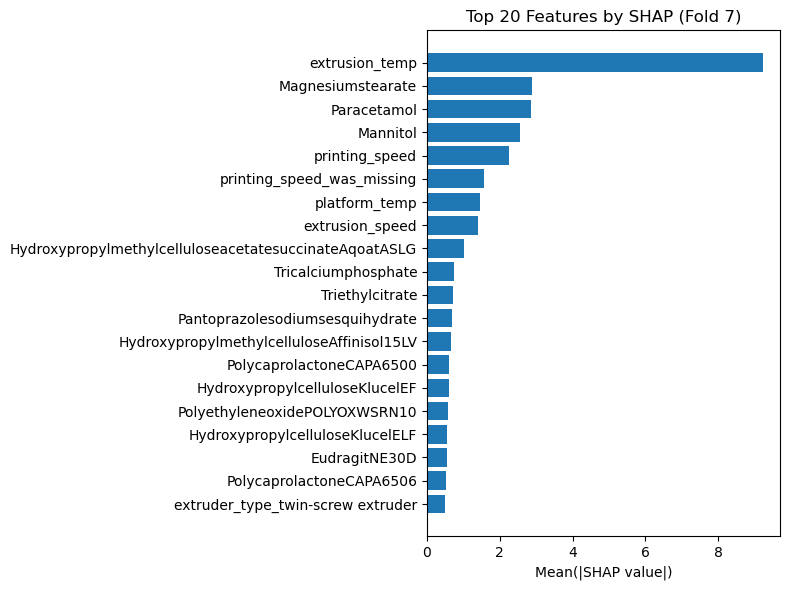

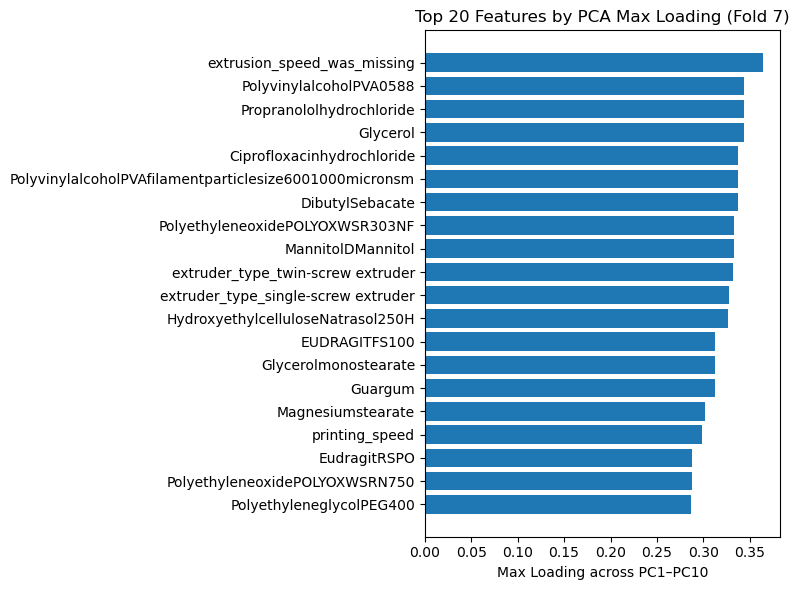

R2: 0.8134, RMSE: 12.7366, MAE: 8.1381

📘 Fold 8/10
R2: 0.8426, RMSE: 12.2235, MAE: 8.4861

📘 Fold 9/10
R2: 0.8522, RMSE: 10.0200, MAE: 6.2597

📘 Fold 10/10
R2: 0.7784, RMSE: 13.4403, MAE: 9.2912

✅ 交叉验证平均指标:
    Fold        R2       RMSE       MAE
0     1  0.871666  13.082652  8.188412
1     2  0.847763  10.111981  7.044080
2     3  0.779653  16.461967  9.090107
3     4  0.924753  10.412578  5.818289
4     5  0.839213  14.925557  8.284842
5     6  0.864986  13.833687  8.574840
6     7  0.813369  12.736561  8.138065
7     8  0.842582  12.223508  8.486130
8     9  0.852229  10.020020  6.259651
9    10  0.778359  13.440297  9.291240

📊 平均 ± 标准差:
            Mean       Std
R2     0.841457  0.043661
RMSE  12.724881  2.119220
MAE    7.917566  1.163930
🎯 推荐展示的折数为 Fold 7
平均 Train RMSE: 7.24140170485786
平均 Eval RMSE: 13.418665226576218
差距: 6.177263521718358


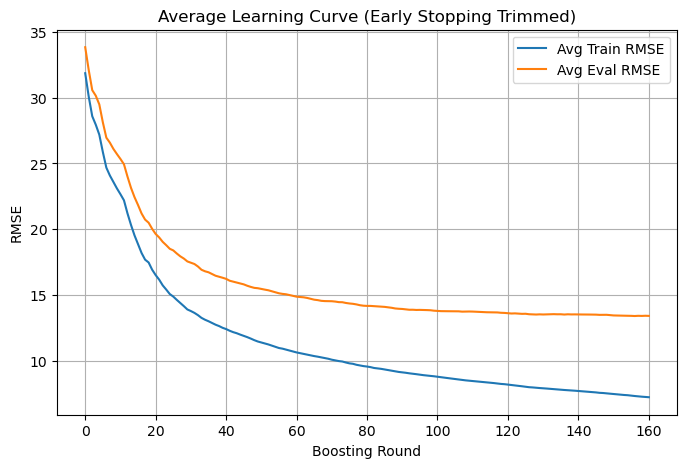

In [4]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold

# ==== 参数设定 ====
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 5,                # 再略降一阶
    'eta': 0.1,                   # 稍再降速，防跳步
    'subsample': 0.7,              # 增加随机性，防止过拟合
    'colsample_bytree': 0.7,
    'lambda': 2.0,                 # 增强 L2 正则
    'alpha': 1.0,                  # 增强 L1 正则
    'seed': 42
}


# ==== 数据准备 ====
X_input = X_train_filled.copy()
y_input = y_train.copy()

# ==== 10折交叉验证 ====
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_metrics = []
fold_learning_curves = []  # ✅ 正确，list 类型，才能 append


for fold, (train_idx, val_idx) in enumerate(kf.split(X_input), 1):
    print(f"\n📘 Fold {fold}/{n_splits}")

    X_train, X_val = X_input.iloc[train_idx], X_input.iloc[val_idx]
    y_train_fold, y_val_fold = y_input.iloc[train_idx], y_input.iloc[val_idx]

    # 转为 DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train_fold)
    dval = xgb.DMatrix(X_val, label=y_val_fold)

    evals = [(dtrain, 'train'), (dval, 'eval')]
    evals_result = {}

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=800,
        evals=evals,
        early_stopping_rounds=30,
        evals_result=evals_result,
        verbose_eval=False
    )
    fold_learning_curves.append(evals_result.copy())

    # === 评估指标 ===
    y_pred = model.predict(dval)
    r2 = r2_score(y_val_fold, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))
    mae = mean_absolute_error(y_val_fold, y_pred)


    # ===== 可视化 Fold 7 的散点图和残差直方图 =====
    if fold == 7:
        y_val_array = np.array(y_val_fold)
        y_pred_array = np.array(y_pred)
        residuals = y_val_array - y_pred_array
    
        plt.figure(figsize=(12, 5))
    
        # --- 1. True vs Predicted ---
        plt.subplot(1, 2, 1)
        plt.scatter(y_val_array, y_pred_array, alpha=0.6)
        plt.plot([y_val_array.min(), y_val_array.max()],
                 [y_val_array.min(), y_val_array.max()], 'r--')
        plt.xlabel("True Values")
        plt.ylabel("Predicted Values")
        plt.title("True vs Predicted")
    
        # --- 2. Residual Histogram ---
        plt.subplot(1, 2, 2)
        plt.hist(residuals, bins=30, color='skyblue', edgecolor='black')
        plt.axvline(0, color='red', linestyle='--')
        plt.xlabel("Residual (True - Predicted)")
        plt.ylabel("Frequency")
        plt.title("Residual Histogram")
    
        plt.tight_layout()
        plt.show()
        
        print("🎯 当前是 Fold 7，开始 SHAP 和 PCA 分析...")
    
        import shap
        import pandas as pd
        from sklearn.decomposition import PCA
        from sklearn.preprocessing import StandardScaler
        import matplotlib.pyplot as plt
    
        # ===== SHAP 分析 =====
        shap.initjs()
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_val)
    
        # === SHAP Top50 特征提取 ===
        mean_shap = np.abs(shap_values).mean(axis=0)
        shap_df = pd.DataFrame({
            'feature': X_val.columns,
            'mean_abs_shap': mean_shap
        }).sort_values(by='mean_abs_shap', ascending=False)
    
        shap_top_50 = shap_df.head(50)
        shap_top_features = shap_top_50['feature'].tolist()
    
        # === SHAP Top20 可视化 ===
        # 小提琴图
        shap.summary_plot(shap_values[:, shap_df.index[:20]], X_val[shap_top_features[:20]], plot_type='violin')
    
        # Bar 图
        plt.figure(figsize=(8, 6))
        plt.barh(shap_top_50['feature'][:20][::-1], shap_top_50['mean_abs_shap'][:20][::-1])
        plt.xlabel("Mean(|SHAP value|)")
        plt.title("Top 20 Features by SHAP")
        plt.tight_layout()
        plt.show()
    
        # ===== PCA 分析 =====
        X_val_scaled = StandardScaler().fit_transform(X_val)
    
        pca = PCA(n_components=10, random_state=42)
        X_pca = pca.fit_transform(X_val_scaled)
        loadings = np.abs(pca.components_)  # shape: (n_components, n_features)
        max_loading_per_feature = loadings.max(axis=0)
    
        # === PCA Top50 特征提取 ===
        pca_df = pd.DataFrame({
            'feature': X_val.columns,
            'max_loading': max_loading_per_feature
        }).sort_values(by='max_loading', ascending=False)
    
        pca_top_50 = pca_df.head(50)
        pca_top_features = pca_top_50['feature'].tolist()
    
        # === PCA Top20 bar 图 ===
        plt.figure(figsize=(8, 6))
        plt.barh(pca_top_50['feature'][:20][::-1], pca_top_50['max_loading'][:20][::-1])
        plt.xlabel("Max Loading across PC1–PC10")
        plt.title("Top 20 Features by PCA Max Loading")
        plt.tight_layout()
        plt.show()

    
    fold_metrics.append([fold, r2, rmse, mae])
    fold_learning_curves.append(evals_result.copy())  # ✅ 正确


    print(f"R2: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

# ==== 输出总结果表 ====
results_df = pd.DataFrame(fold_metrics, columns=["Fold", "R2", "RMSE", "MAE"])
mean_std = results_df[["R2", "RMSE", "MAE"]].agg(['mean', 'std']).T
mean_std.columns = ['Mean', 'Std']
print("\n✅ 交叉验证平均指标:\n", results_df)
print("\n📊 平均 ± 标准差:\n", mean_std)
# 选择 RMSE 最接近平均值的那一折作为展示
mean_rmse = np.mean([rmse for _, _, rmse, _ in fold_metrics])
closest_idx = np.argmin([abs(rmse - mean_rmse) for _, _, rmse, _ in fold_metrics])
print(f"🎯 推荐展示的折数为 Fold {closest_idx+1}")

# ==== 计算10 fold平均学习曲线 ====
# 先找最短的训练轮数（所有折中最短的）
min_rounds = min(len(res['train']['rmse']) for res in fold_learning_curves)

# 初始化数组
train_rmse_all = np.zeros((n_splits, min_rounds))
eval_rmse_all = np.zeros((n_splits, min_rounds))

# 填入每一折的前 min_rounds 轮数据
for i, evals_result in enumerate(fold_learning_curves[:n_splits]):
    train_rmse_all[i, :] = evals_result['train']['rmse'][:min_rounds]
    eval_rmse_all[i, :] = evals_result['eval']['rmse'][:min_rounds]

# 求平均曲线
mean_train_rmse = np.mean(train_rmse_all, axis=0)
mean_eval_rmse = np.mean(eval_rmse_all, axis=0)

print("平均 Train RMSE:", mean_train_rmse[-1])
print("平均 Eval RMSE:", mean_eval_rmse[-1])
print("差距:", mean_eval_rmse[-1] - mean_train_rmse[-1])

# 画图
plt.figure(figsize=(8, 5))
plt.plot(mean_train_rmse, label='Avg Train RMSE')
plt.plot(mean_eval_rmse, label='Avg Eval RMSE')
plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.title('Average Learning Curve (Early Stopping Trimmed)')
plt.legend()
plt.grid(True)
plt.show()


In [5]:
from collections import Counter
from sklearn.preprocessing import StandardScaler

# 特征并集（不去交集，只用于打印）
all_top_features = shap_top_features + pca_top_features
selected_features = list(set(all_top_features))  # ✅ 并集

# 打印交集，仅供参考
feature_counter = Counter(all_top_features)
overlapped_features = [feat for feat, count in feature_counter.items() if count == 2]
print(f"👀 SHAP和PCA交集特征数: {len(overlapped_features)}\n{overlapped_features}")
print(f"✅ 最终用于建模的特征数（并集）: {len(selected_features)}")

# 标准化特征
X_selected = X_train_filled[selected_features]
feature_names = X_selected.columns

scaler = StandardScaler()
X_selected_scaled = pd.DataFrame(scaler.fit_transform(X_selected), columns=feature_names)

# 测试集也准备好
X_test_selected = X_test_filled[selected_features]
X_test_scaled = scaler.transform(X_test_selected)


👀 SHAP和PCA交集特征数: 23
['extrusion_temp', 'Magnesiumstearate', 'Paracetamol', 'Mannitol', 'printing_speed', 'platform_temp', 'extrusion_speed', 'Tricalciumphosphate', 'Triethylcitrate', 'HydroxypropylcelluloseKlucelEF', 'EudragitNE30D', 'extruder_type_twin-screw extruder', 'EthylcelluloseAqualonN50', 'filament_aspect_Good', 'nozzle_diameter_was_missing', 'EudragitEPO', 'EudragitRLPO', 'extruder_type_single-screw extruder', 'printability_yes', 'PolycaprolactoneMW80000grinded', 'nozzle_diameter', 'extrusion_speed_was_missing', 'HydroxyethylcelluloseNatrasol250H']
✅ 最终用于建模的特征数（并集）: 77


In [6]:
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

X_selected_input = X_selected_scaled
y_selected_input = y_train.values

n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_metrics = []
fold_learning_curves = []

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 5,
    'eta': 0.1,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'lambda':2.0,
    'alpha':1.0,
    'seed': 42
}

for fold, (train_idx, val_idx) in enumerate(kf.split(X_selected_input), 1):
    print(f"\n📘 Fold {fold}/{n_splits}")
    
    X_select_train = X_selected_input.iloc[train_idx]
    X_select_val = X_selected_input.iloc[val_idx]
    y_select_train_fold = y_selected_input[train_idx]
    y_select_val_fold = y_selected_input[val_idx]

    dtrain = xgb.DMatrix(X_select_train, label=y_select_train_fold)
    dval = xgb.DMatrix(X_select_val, label=y_select_val_fold)

    evals_result = {}
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=800,
        early_stopping_rounds=30,
        evals=[(dtrain, 'train'), (dval, 'eval')],
        evals_result=evals_result,
        verbose_eval=False
    )

    y_pred = model.predict(dval)
    r2 = r2_score(y_select_val_fold, y_pred)
    rmse = np.sqrt(mean_squared_error(y_select_val_fold, y_pred))
    mae = mean_absolute_error(y_select_val_fold, y_pred)

    fold_metrics.append([fold, r2, rmse, mae])
    fold_learning_curves.append(evals_result.copy())

    if fold == 7:
        fold7_model = model
        X_val = X_select_val.copy()
        y_val_array = np.array(y_select_val_fold)
        y_pred_array = np.array(y_pred)




📘 Fold 1/10

📘 Fold 2/10

📘 Fold 3/10

📘 Fold 4/10

📘 Fold 5/10

📘 Fold 6/10

📘 Fold 7/10

📘 Fold 8/10

📘 Fold 9/10

📘 Fold 10/10


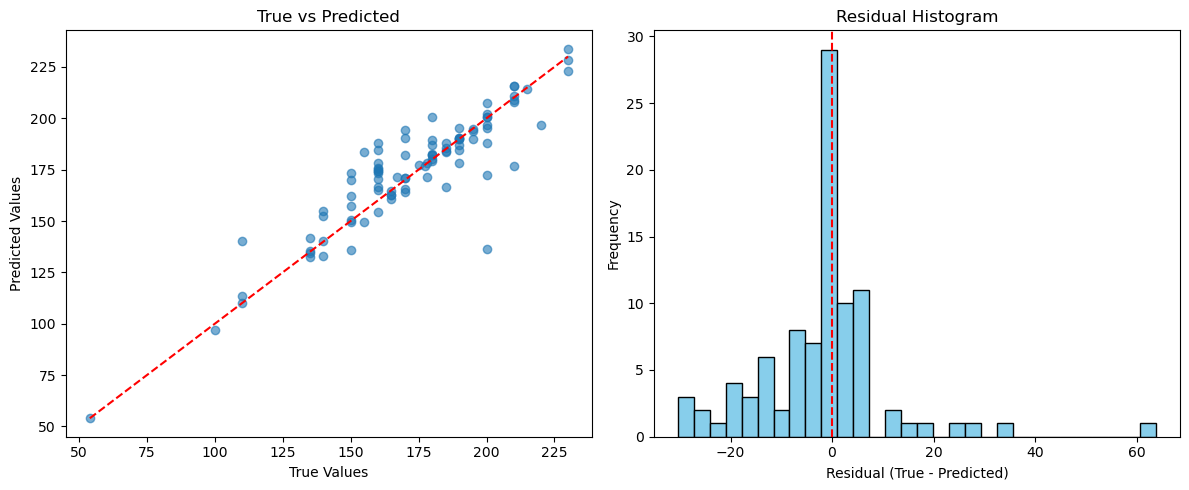

In [7]:
# 残差计算
residuals = y_val_array - y_pred_array  # ✅ 变量已在 fold==7 中定义

plt.figure(figsize=(12, 5))

# 1. True vs Predicted
plt.subplot(1, 2, 1)
plt.scatter(y_val_array, y_pred_array, alpha=0.6)
plt.plot([y_val_array.min(), y_val_array.max()],
         [y_val_array.min(), y_val_array.max()], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted")

# 2. Residual Histogram
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Residual (True - Predicted)")
plt.ylabel("Frequency")
plt.title("Residual Histogram")

plt.tight_layout()
plt.show()



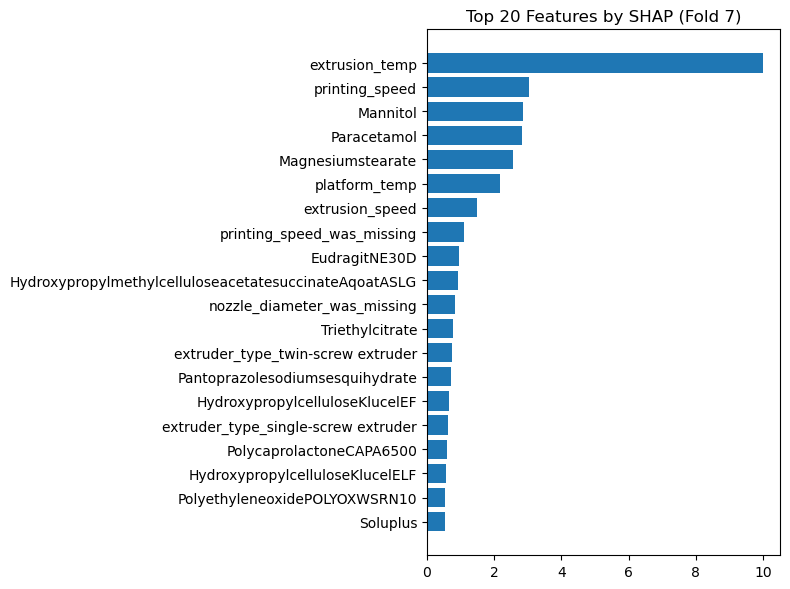

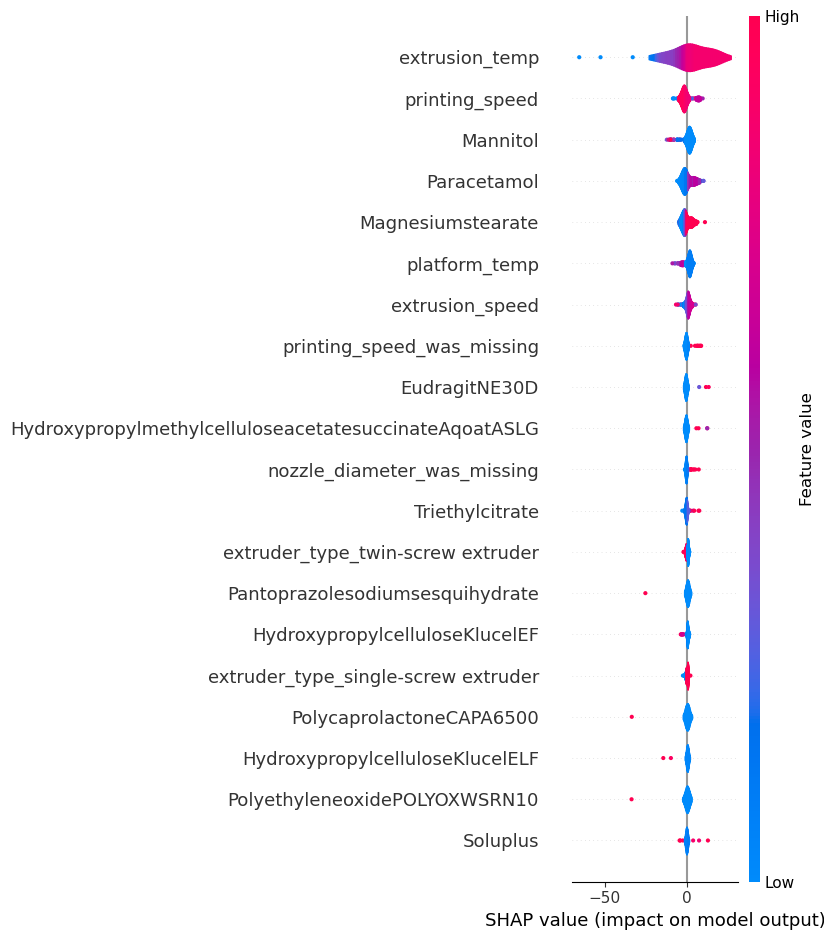

In [8]:
import shap
shap.initjs()

X_val_sample = X_val.copy()


explainer = shap.TreeExplainer(fold7_model)
shap_values = explainer.shap_values(X_val_sample)

mean_shap = np.abs(shap_values).mean(axis=0)
shap_df = pd.DataFrame({
    'feature': X_val_sample.columns,
    'mean_abs_shap': mean_shap
}).sort_values(by='mean_abs_shap', ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(shap_df['feature'][:20][::-1], shap_df['mean_abs_shap'][:20][::-1])
plt.title("Top 20 Features by SHAP")
plt.tight_layout()
plt.show()

shap.summary_plot(
    shap_values[:, shap_df.index[:20]],
    X_val_sample.iloc[:, shap_df.index[:20]],
    plot_type='violin'
)


📘 当前是 Fold 7，开始 PCA 分析...


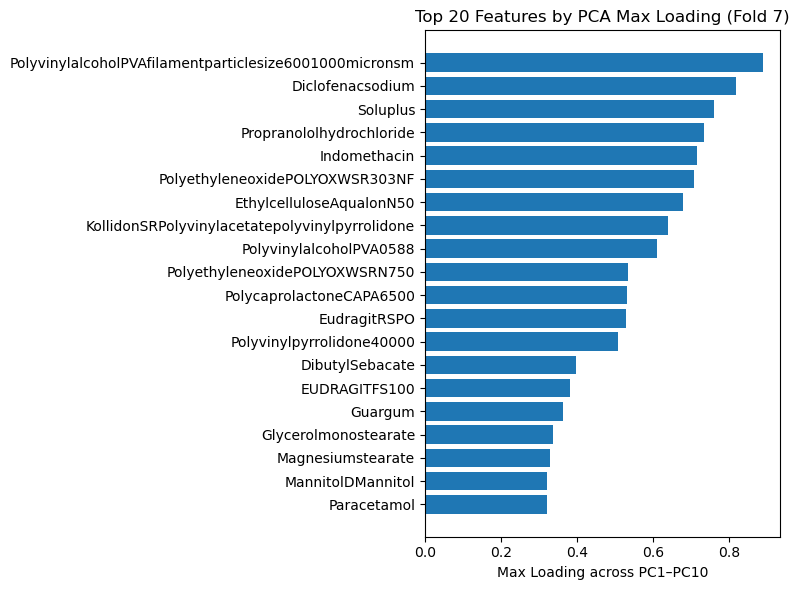

In [9]:
print("📘 当前是 Fold 7，开始 PCA 分析...")

pca = PCA(n_components=10, random_state=42)
X_pca = pca.fit_transform(X_val_sample)

loadings = np.abs(pca.components_)
max_loading_per_feature = loadings.max(axis=0)

pca_df = pd.DataFrame({
    'feature': X_val_sample.columns,
    'max_loading': max_loading_per_feature
}).sort_values(by='max_loading', ascending=False)

# 绘制 Top 20 特征的 Loading 图
plt.figure(figsize=(8, 6))
plt.barh(pca_df['feature'][:20][::-1], pca_df['max_loading'][:20][::-1])
plt.xlabel("Max Loading across PC1–PC10")
plt.title("Top 20 Features by PCA Max Loading")
plt.tight_layout()
plt.show()


📊 每折指标如下: 
    Fold        R2       RMSE       MAE
0     1  0.870863  13.123507  8.404308
1     2  0.888886   8.638940  5.534156
2     3  0.811599  15.221909  8.449854
3     4  0.924070  10.459730  5.884098
4     5  0.863818  13.736146  8.079278
5     6  0.888365  12.579050  7.981260
6     7  0.805108  13.015390  8.174567
7     8  0.790125  14.113972  9.523571
8     9  0.856664   9.868503  6.081220
9    10  0.784957  13.238718  8.371504

📌 平均 ± 标准差: 
          mean     std
R2     0.8484  0.0476
RMSE  12.3996  2.0721
MAE    7.6484  1.3277
平均 Train RMSE: 6.8100028618923805
平均 Eval RMSE: 12.631524084140276
差距: 5.821521222247895


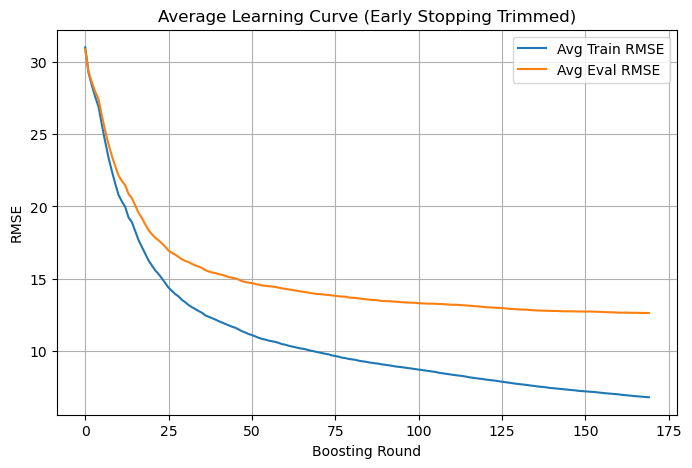

In [10]:
# 打印每折的 R2、RMSE、MAE 结果
results_df = pd.DataFrame(fold_metrics, columns=["Fold", "R2", "RMSE", "MAE"])

mean_std = results_df[["R2", "RMSE", "MAE"]].agg(['mean', 'std']).T

print("📊 每折指标如下: \n", results_df)
print("\n📌 平均 ± 标准差: \n", mean_std.round(4))

# ==== 计算10 fold平均学习曲线 ====
# 先检查所有fold的最小 early stopping 轮数（防止后面索引越界）
min_rounds = min(len(res['train']['rmse']) for res in fold_learning_curves)

# 初始化矩阵
train_rmse_all = np.zeros((n_splits, min_rounds))
eval_rmse_all = np.zeros((n_splits, min_rounds))

# 将每一折的前 min_rounds 提取出来
for i, evals_result in enumerate(fold_learning_curves):
    train_rmse_all[i, :] = evals_result['train']['rmse'][:min_rounds]
    eval_rmse_all[i, :] = evals_result['eval']['rmse'][:min_rounds]

# 求平均
mean_train_rmse = np.mean(train_rmse_all, axis=0)
mean_eval_rmse = np.mean(eval_rmse_all, axis=0)

print("平均 Train RMSE:", mean_train_rmse[-1])
print("平均 Eval RMSE:", mean_eval_rmse[-1])
print("差距:", mean_eval_rmse[-1] - mean_train_rmse[-1])

# ==== 可视化 ====
plt.figure(figsize=(8, 5))
plt.plot(mean_train_rmse, label='Avg Train RMSE')
plt.plot(mean_eval_rmse, label='Avg Eval RMSE')
plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.title('Average Learning Curve (Early Stopping Trimmed)')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8, None],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

# 数据
X = X_selected_scaled
y = y_train.values

# 网格搜索参数
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# 网格搜索（内含5折CV）
grid_search = GridSearchCV(RandomForestRegressor(random_state=42),
                           param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X, y)
best_rf = grid_search.best_estimator_

print("✅ 最佳参数：", grid_search.best_params_)

# === 用最佳模型做 10-fold CV 评估 ===
kf = KFold(n_splits=10, shuffle=True, random_state=42)

r2_list, rmse_list, mae_list = [], [], []

for train_idx, val_idx in kf.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val = y[train_idx], y[val_idx]

    best_rf.fit(X_train, y_train_fold)
    y_pred = best_rf.predict(X_val)

    r2 = r2_score(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)

    r2_list.append(r2)
    rmse_list.append(rmse)
    mae_list.append(mae)

# 打印平均指标
print(f"📊 RandomForest (10-fold CV):")
print(f"R2: {np.mean(r2_list):.4f} ± {np.std(r2_list):.4f}")
print(f"RMSE: {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")
print(f"MAE: {np.mean(mae_list):.4f} ± {np.std(mae_list):.4f}")


# ========= 使用最佳参数的模型评估测试集 =========
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# 预测测试集
y_test_pred = best_rf.predict(X_test_scaled)

# 计算评估指标
r2_test = r2_score(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)

print("\n📊 RandomForest 测试集评估：")
print(f"R2:   {r2_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")
print(f"MAE:  {mae_test:.4f}")



Fitting 5 folds for each of 16 candidates, totalling 80 fits
✅ 最佳参数： {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100}
📊 RandomForest (10-fold CV):
R2: 0.5553 ± 0.0485
RMSE: 21.6051 ± 2.8912
MAE: 16.7435 ± 2.0380

📊 RandomForest 测试集评估：
R2:   0.6055
RMSE: 19.8853
MAE:  14.6235


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Fitting 5 folds for each of 27 candidates, totalling 135 fits
✅ 最佳参数： {'depth': 8, 'iterations': 300, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
📊 CatBoost (10-fold CV):
R2: 0.8694 ± 0.0349
RMSE: 11.5373 ± 1.5502
MAE: 7.1523 ± 1.0173

🧪 CatBoost 测试集评估:
R2:   0.8702
RMSE: 11.4050
MAE:  7.0477


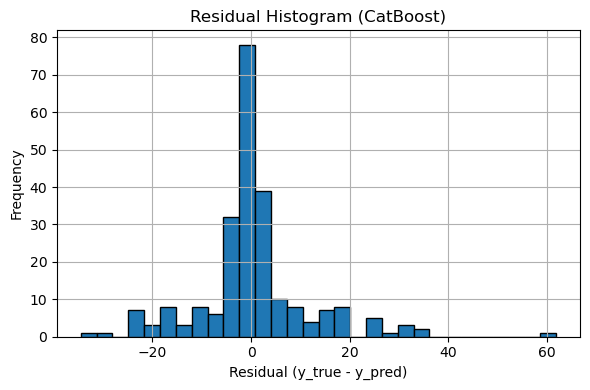

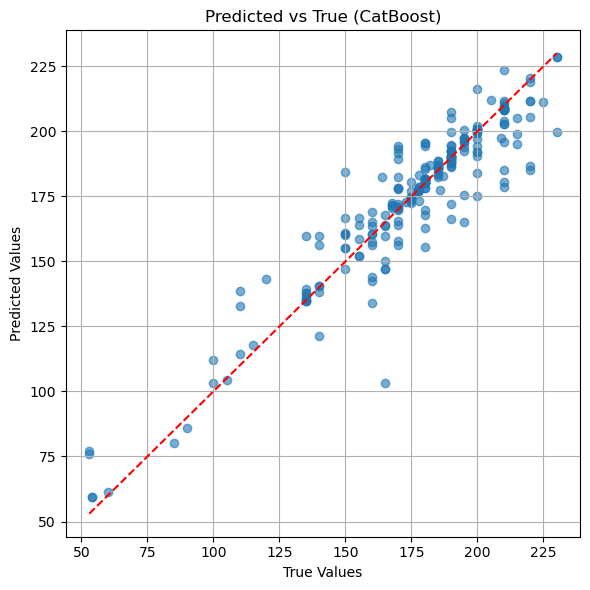

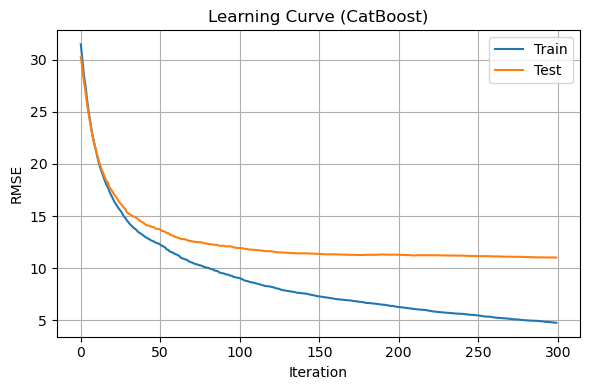

✅ 最后一轮训练集 RMSE: 4.7436
✅ 最后一轮测试集 RMSE: 11.0118
📉 训练与测试 RMSE 差值（过拟合指标）: 6.2683


In [23]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd


# 参数网格
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5],
    'iterations': [300]
}

# 网格搜索
grid_search = GridSearchCV(
    CatBoostRegressor(verbose=0, random_state=42),
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X, y)
best_cat = grid_search.best_estimator_

print("✅ 最佳参数：", grid_search.best_params_)

# === 10-fold 交叉验证 ===
kf = KFold(n_splits=10, shuffle=True, random_state=42)
r2_list, rmse_list, mae_list = [], [], []

for train_idx, val_idx in kf.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val = y[train_idx], y[val_idx]

    best_cat.fit(X_train, y_train_fold, verbose=0)
    y_pred = best_cat.predict(X_val)

    r2 = r2_score(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)

    r2_list.append(r2)
    rmse_list.append(rmse)
    mae_list.append(mae)

# 打印平均结果
print(f"📊 CatBoost (10-fold CV):")
print(f"R2: {np.mean(r2_list):.4f} ± {np.std(r2_list):.4f}")
print(f"RMSE: {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")
print(f"MAE: {np.mean(mae_list):.4f} ± {np.std(mae_list):.4f}")

# === 📌 测试集评估 ===
best_cat.fit(X, y)  # 在整个训练集上重新训练
y_pred_test = best_cat.predict(X_test_scaled)

r2_test = r2_score(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)

print("\n🧪 CatBoost 测试集评估:")
print(f"R2:   {r2_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")
print(f"MAE:  {mae_test:.4f}")

import matplotlib.pyplot as plt

residuals = y_test - y_pred_test

plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=30, edgecolor='black')
plt.title("Residual Histogram (CatBoost)")
plt.xlabel("Residual (y_true - y_pred)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 对角线
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs True (CatBoost)")
plt.grid(True)
plt.tight_layout()
plt.show()

from catboost import Pool
from catboost import Pool, CatBoostRegressor
import matplotlib.pyplot as plt

# 构造训练集和验证集
train_pool = Pool(X_selected_scaled, y_train)
eval_pool = Pool(X_test_scaled, y_test)

# 去掉已有 iterations 再手动设置
best_params_for_plot = grid_search.best_params_.copy()
best_params_for_plot.pop('iterations', None)

# 构建模型
model_for_plot = CatBoostRegressor(**best_params_for_plot, iterations=300, verbose=0)

# 训练并记录评估数据
model_for_plot.fit(train_pool, eval_set=eval_pool, use_best_model=False)
evals_result = model_for_plot.get_evals_result()


# 可视化学习曲线
plt.figure(figsize=(6, 4))
plt.plot(evals_result['learn']['RMSE'], label='Train')
plt.plot(evals_result['validation']['RMSE'], label='Test')
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.title("Learning Curve (CatBoost)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 获取最后一轮的 RMSE
train_rmse_final = evals_result['learn']['RMSE'][-1]
test_rmse_final = evals_result['validation']['RMSE'][-1]
rmse_gap = test_rmse_final - train_rmse_final

# 打印结果
print(f"✅ 最后一轮训练集 RMSE: {train_rmse_final:.4f}")
print(f"✅ 最后一轮测试集 RMSE: {test_rmse_final:.4f}")
print(f"📉 训练与测试 RMSE 差值（过拟合指标）: {rmse_gap:.4f}")


📊 测试集评估：
R2:   0.8452
RMSE: 12.4559
MAE:  8.8562


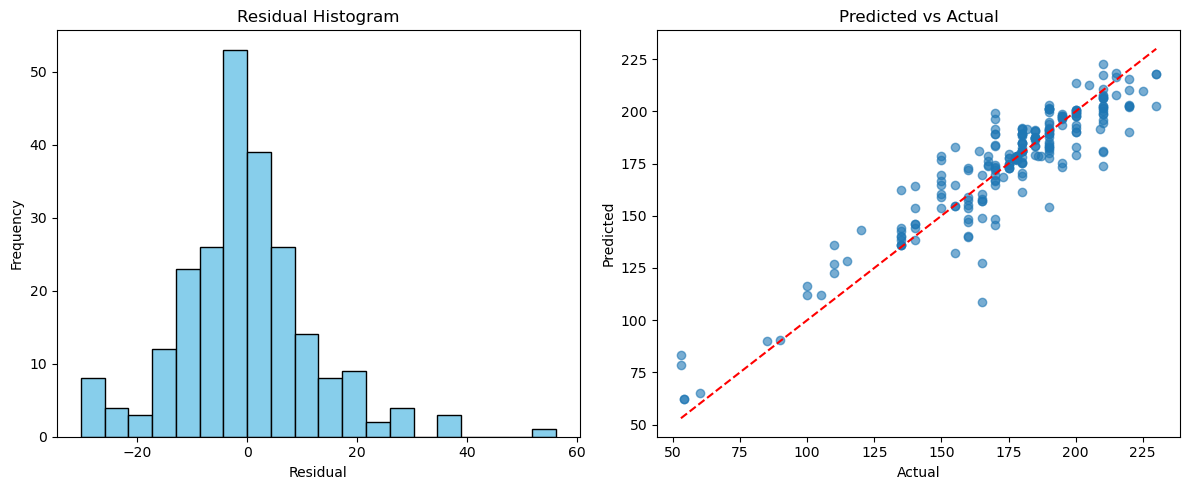

Training on fold [0/10]

bestTest = 18.56952341
bestIteration = 798

Training on fold [1/10]

bestTest = 12.55956718
bestIteration = 799

Training on fold [2/10]

bestTest = 11.50160089
bestIteration = 799

Training on fold [3/10]

bestTest = 13.57906436
bestIteration = 798

Training on fold [4/10]

bestTest = 12.32018893
bestIteration = 768

Training on fold [5/10]

bestTest = 12.42992345
bestIteration = 799

Training on fold [6/10]

bestTest = 13.85047688
bestIteration = 799

Training on fold [7/10]

bestTest = 14.75156214
bestIteration = 799

Training on fold [8/10]

bestTest = 15.71995509
bestIteration = 799

Training on fold [9/10]

bestTest = 16.39431889
bestIteration = 795


📉 学习曲线终轮RMSE:
Train RMSE: 10.5898
Test  RMSE: 14.1689
差距（Test - Train）: 3.5791


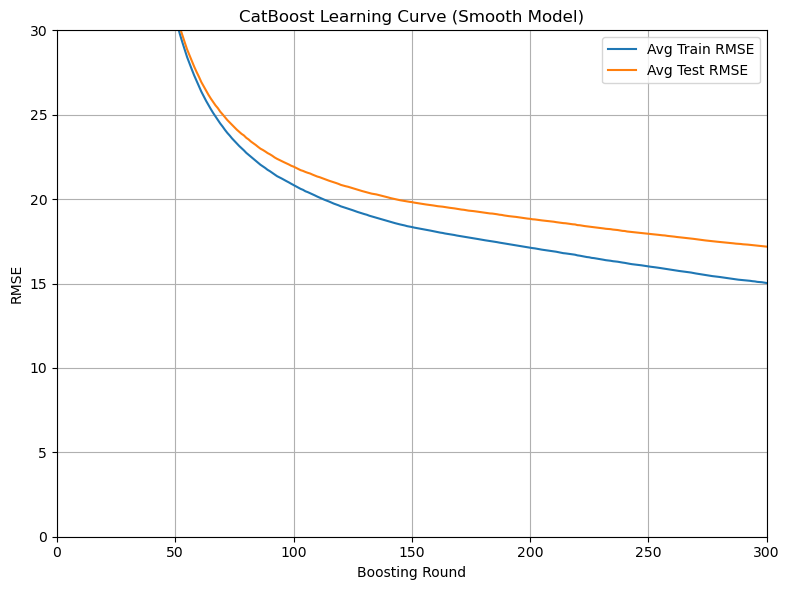

In [22]:
from catboost import CatBoostRegressor, Pool, cv
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# 替换为你实际的数据变量
X_train = X_selected_scaled
y_train = y_train
X_test = X_test_scaled
y_test = y_test

# ========== 1. 训练更平滑的 CatBoost ==========
smooth_cat = CatBoostRegressor(
    iterations=800,
    learning_rate=0.05,
    depth=5,
    l2_leaf_reg=20,
    bootstrap_type='Bernoulli',
    subsample=0.8,
    early_stopping_rounds=50,
    loss_function='RMSE',
    random_seed=42,
    verbose=0
)

smooth_cat.fit(X_train, y_train)

# ========== 2. 测试集评估 ==========
y_pred = smooth_cat.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("📊 测试集评估：")
print(f"R2:   {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")

# ========== 3. 残差分析图 ==========
residuals = y_test - y_pred
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(residuals, bins=20, color='skyblue', edgecolor='black')
axes[0].set_title("Residual Histogram")
axes[0].set_xlabel("Residual")
axes[0].set_ylabel("Frequency")

axes[1].scatter(y_test, y_pred, alpha=0.6)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[1].set_title("Predicted vs Actual")
axes[1].set_xlabel("Actual")
axes[1].set_ylabel("Predicted")

plt.tight_layout()
plt.show()

# ========== 4. 学习曲线 ==========
params = smooth_cat.get_params()
params.update({
    'loss_function': 'RMSE',
    'early_stopping_rounds': 50,
    'verbose': False,
    'random_seed': 42
})
train_pool = Pool(X_train, y_train)
cv_results = cv(
    pool=train_pool,
    params=params,
    fold_count=10,
    shuffle=True,
    partition_random_seed=42,
    verbose=False,
    plot=False
)

train_rmse = cv_results['train-RMSE-mean']
test_rmse = cv_results['test-RMSE-mean']

last_train_rmse = train_rmse.iloc[-1]
last_test_rmse = test_rmse.iloc[-1]
print(f"\n📉 学习曲线终轮RMSE:")
print(f"Train RMSE: {last_train_rmse:.4f}")
print(f"Test  RMSE: {last_test_rmse:.4f}")
print(f"差距（Test - Train）: {last_test_rmse - last_train_rmse:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(train_rmse, label="Avg Train RMSE")
plt.plot(test_rmse, label="Avg Test RMSE")
plt.xlabel("Boosting Round")
plt.ylabel("RMSE")
plt.title("CatBoost Learning Curve (Smooth Model)")
plt.xlim(0, 300)
plt.ylim(0, 30)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

# 防止过拟合的调参空间（小网络 + 强正则）
param_grid = {
    'hidden_layer_sizes': [(64,), (64, 32), (128, 64)],
    'alpha': [1e-4, 1e-3, 1e-2],  # L2 正则化
    'learning_rate_init': [0.001, 0.01],
    'activation': ['relu'],
    'solver': ['adam'],
    'early_stopping': [True]
}

# 网格搜索
mlp = MLPRegressor(max_iter=500, random_state=42)
grid_search = GridSearchCV(
    mlp,
    param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X, y)
best_mlp = grid_search.best_estimator_

print("✅ 最佳参数：", grid_search.best_params_)

# === 用最佳模型做 10-fold CV ===
kf = KFold(n_splits=10, shuffle=True, random_state=42)
r2_list, rmse_list, mae_list = [], [], []

for train_idx, val_idx in kf.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val = y[train_idx], y[val_idx]

    best_mlp.fit(X_train, y_train_fold)
    y_pred = best_mlp.predict(X_val)

    r2_list.append(r2_score(y_val, y_pred))
    rmse_list.append(np.sqrt(mean_squared_error(y_val, y_pred)))  # 改这里
    mae_list.append(mean_absolute_error(y_val, y_pred))


# 打印平均结果
print("\n📊 MLP (10-fold CV):")
print(f"R2:   {np.mean(r2_list):.4f} ± {np.std(r2_list):.4f}")
print(f"RMSE: {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")
print(f"MAE:  {np.mean(mae_list):.4f} ± {np.std(mae_list):.4f}")


# === 📌 测试集评估 ===
best_mlp.fit(X, y)  # 在整个训练集上重新训练
y_pred_test = best_mlp.predict(X_test_scaled)

r2_test = r2_score(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)

print("\n🧪 MLP 测试集评估:")
print(f"R2:   {r2_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")
print(f"MAE:  {mae_test:.4f}")


Fitting 5 folds for each of 18 candidates, totalling 90 fits
✅ 最佳参数： {'activation': 'relu', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': (64, 32), 'learning_rate_init': 0.01, 'solver': 'adam'}

📊 MLP (10-fold CV):
R2:   0.5107 ± 0.3239
RMSE: 20.6869 ± 4.3872
MAE:  11.9387 ± 2.1684

🧪 MLP 测试集评估:
R2:   0.2497
RMSE: 27.4241
MAE:  12.0456


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


In [14]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# === 定义模型和搜索空间 ===
svr = SVR()
param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.5],
    'kernel': ['rbf']
}

# === 网格搜索 + 5折CV ===
grid_search = GridSearchCV(
    svr,
    param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X, y)

best_svr = grid_search.best_estimator_
print("✅ 最佳参数:", grid_search.best_params_)

# === 10-Fold 验证 ===
kf = KFold(n_splits=10, shuffle=True, random_state=42)
r2_list, rmse_list, mae_list = [], [], []

for train_idx, val_idx in kf.split(X):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]
    
    best_svr.fit(X_train_fold, y_train_fold)
    y_pred = best_svr.predict(X_val_fold)
    
    r2_list.append(r2_score(y_val_fold, y_pred))
    rmse_list.append(np.sqrt(mean_squared_error(y_val_fold, y_pred)))  # 改这里
    mae_list.append(mean_absolute_error(y_val_fold, y_pred))

# === 输出平均指标 ===
print("\n📊 SVR (10-fold CV):")
print(f"R2: {np.mean(r2_list):.4f} ± {np.std(r2_list):.4f}")
print(f"RMSE: {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")
print(f"MAE: {np.mean(mae_list):.4f} ± {np.std(mae_list):.4f}")

# === 🧪 测试集评估 ===
best_svr.fit(X, y)  # 在整个训练集上重新训练
y_pred_test = best_svr.predict(X_test_scaled)

r2_test = r2_score(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)

print("\n🧪 SVR 测试集评估:")
print(f"R2:   {r2_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")
print(f"MAE:  {mae_test:.4f}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
✅ 最佳参数: {'C': 10, 'epsilon': 0.5, 'kernel': 'rbf'}

📊 SVR (10-fold CV):
R2: 0.6511 ± 0.0836
RMSE: 19.2118 ± 4.1026
MAE: 11.9019 ± 2.1832

🧪 SVR 测试集评估:
R2:   0.7189
RMSE: 16.7846
MAE:  10.7502


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


In [17]:
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


# 转成DMatrix格式
dtrain = xgb.DMatrix(X, label=y)

# ==== 参数搜索 ====
param_grid = {
    'max_depth': [3, 5, 7],
    'eta': [0.05, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

best_params = None
best_score = float("inf")

for md in param_grid['max_depth']:
    for eta in param_grid['eta']:
        for ss in param_grid['subsample']:
            for csbt in param_grid['colsample_bytree']:
                params = {
                    'max_depth': md,
                    'eta': eta,
                    'subsample': ss,
                    'colsample_bytree': csbt,
                    'objective': 'reg:squarederror',
                    'eval_metric': 'rmse',
                    'seed': 42
                }
                cv_results = xgb.cv(
                    params,
                    dtrain,
                    num_boost_round=300,
                    nfold=5,
                    early_stopping_rounds=20,
                    metrics='rmse',
                    verbose_eval=False
                )
                mean_rmse = cv_results['test-rmse-mean'].min()
                if mean_rmse < best_score:
                    best_score = mean_rmse
                    best_params = params
                    best_num_round = cv_results['test-rmse-mean'].idxmin()

print("✅ 最佳参数：", best_params)
print("✅ 最佳轮数：", best_num_round)

# ==== 用最佳参数做 10-fold CV ====
kf = KFold(n_splits=10, shuffle=True, random_state=42)

r2_list, rmse_list, mae_list = [], [], []

for train_idx, val_idx in kf.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val = y[train_idx], y[val_idx]

    dtrain_fold = xgb.DMatrix(X_train, label=y_train_fold)
    dval = xgb.DMatrix(X_val)

    evals_result = {}
    model = xgb.train(
        best_params,
        dtrain_fold,
        num_boost_round=best_num_round,
        evals=[(dtrain_fold, 'train')],
        verbose_eval=False
    )

    y_pred = model.predict(dval)

    r2_list.append(r2_score(y_val, y_pred))
    rmse_list.append(np.sqrt(mean_squared_error(y_val, y_pred)))
    mae_list.append(mean_absolute_error(y_val, y_pred))

# ==== 打印结果 ====
print(f"\n📊 XGBoost (10-fold CV):")
print(f"R²:   {np.mean(r2_list):.4f} ± {np.std(r2_list):.4f}")
print(f"RMSE: {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")
print(f"MAE:  {np.mean(mae_list):.4f} ± {np.std(mae_list):.4f}")

# === 🧪 测试集评估 ===
dtrain_full = xgb.DMatrix(X_selected_scaled, label=y)
dtest = xgb.DMatrix(X_test_selected, feature_names=list(X_selected.columns))  # ✅ 修复这里

final_model = xgb.train(
    best_params,
    dtrain_full,
    num_boost_round=best_num_round,
    evals=[(dtrain_full, 'train')],
    verbose_eval=False
)

y_pred_test = final_model.predict(dtest)

r2_test = r2_score(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)

print("\n🧪 XGBoost 测试集评估:")
print(f"R2:   {r2_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")
print(f"MAE:  {mae_test:.4f}")


✅ 最佳参数： {'max_depth': 7, 'eta': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'seed': 42}
✅ 最佳轮数： 295

📊 XGBoost (10-fold CV):
R²:   0.8516 ± 0.0429
RMSE: 12.2540 ± 1.7162
MAE:  7.1420 ± 1.0866

🧪 XGBoost 测试集评估:
R2:   0.8403
RMSE: 12.6527
MAE:  7.9043
